# Práctica IA en Automoviles

{Aquí meter vainas}

En primer lugar, obtenemos los datos que vamos a emplear en el modelo. Para ello, leemos todos los ficheros excel que se pasan como conjunto de datos. Además, aplicamos un primer filtrado a estos datos. En este primer filtrado nos quedamos únicamente con los datos que consideramos que son últiles para el modelo.

Estos datos son:
* El momento temporal en el que se tomaron los datos
* El ángulo del volante
* La fuerza con la que se está pisando el pedal del acelerador
* La fuerza con la que se está pisando el pedal del freno
* La fuerza con la que se está pisando el pedal del embrague
* La marcha en la que se tenía el coche
* La velocidad del vehículo
* Los RPM del motor

Además, incluimos la columna que nos indica si se está realizando el adelantamiento o no.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split # Import train_test_split function
from IPython.display import Image  
from sklearn.tree import export_graphviz

prefix = 'ManiobrasSimulador/Driver'
fichero = 'STISIMData_Overtaking.xlsx'

datos = []

# Leemos los datos de los 5 conductores que se nos pasan como Datasets
for i in range(5):
    indice = i+1

    nombre = prefix + str(indice) + "/" + fichero
    excl = pd.read_excel(nombre)

    # Realizamos un primer filtrado, para quedarnos solo con las columnas que nos interesen
    proc1 = pd.DataFrame({'MomentoTemporal': excl['Elapsed time'],
                          'AnguloVolante': excl['Steering wheel angle'],
                          'Acelerador': excl['Gas pedal'],
                          'PedalFreno': excl['Brake pedal'],
                          'Embrague': excl['Clutch pedal'],
                          'Marcha': excl['Gear'],
                          'Velocidad': excl['speed'],
                          'RPM': excl['RPM'],
                          'FlagManiobra': excl['Maneuver marker flag']})
    datos.append(proc1)

En un primer filtrado se eliminan los datos en los que no se realizan las maniobras y se almacenan las muestras de las mismas por separado. Además se elimina la columna que indica si se esta realizando o no la maniobra ya que no sigue resultando necesaria.

In [6]:
maniobras = []
maniobraEncontrada = False
inicio = 0
fin = 0
for datosConductor in datos:
    for i in range(len(datosConductor)):
        if datosConductor.iloc[i]['FlagManiobra'] == 1 and not maniobraEncontrada:
            inicio = i
            maniobraEncontrada = True
        elif datosConductor.iloc[i]['FlagManiobra'] == 0 and maniobraEncontrada:
            fin = i
            maniobraEncontrada = False
            maniobra = datosConductor[inicio:fin]
            maniobraProcesada = maniobra.drop(columns=['FlagManiobra'], axis=1)
            maniobras.append(maniobraProcesada)

In [7]:
maniobrasPreprocesadas = []
for maniobra in maniobras:
    maniobraPreprocesada = pd.DataFrame(columns=['VariacionVelocidad', 'VariacionRevoluciones', 'VariacionAnguloVolante', 'VariacionAcelerador', 'VariacionFreno', 'VariacionMarcha', 'PedalEmbrague'])
    for i in range(len(maniobra) - 1):
        variacion_velocidad = maniobra.iloc[i + 1]['Velocidad'] - maniobra.iloc[i]['Velocidad']
        variacion_revoluciones = maniobra.iloc[i + 1]['RPM'] - maniobra.iloc[i]['RPM']
        variacion_angulo_volante = maniobra.iloc[i + 1]['AnguloVolante'] - maniobra.iloc[i]['AnguloVolante']
        variacicion_acelerador = maniobra.iloc[i + 1]['Acelerador'] - maniobra.iloc[i]['Acelerador']
        variacion_freno = maniobra.iloc[i + 1]['PedalFreno'] - maniobra.iloc[i]['PedalFreno']
        variacion_marcha = maniobra.iloc[i + 1]['Marcha'] - maniobra.iloc[i]['Marcha']

        if(variacion_velocidad > 0):
            variacion_velocidad = 1
        elif(variacion_velocidad < 0):
            variacion_velocidad = -1
        else:
            variacion_velocidad = 0

        if(variacion_revoluciones > 0):
            variacion_revoluciones = 1
        elif(variacion_revoluciones < 0):
            variacion_revoluciones = -1
        else:
            variacion_revoluciones = 0

        if(variacion_angulo_volante > 0):
            variacion_angulo_volante = 1
        elif(variacion_angulo_volante < 0):
            variacion_angulo_volante = -1
        else:
            variacion_angulo_volante = 0

        if(variacicion_acelerador > 0 or maniobra.iloc[i + 1]['Acelerador'] == 1):
            variacicion_acelerador = 1
        elif(variacicion_acelerador < 0):
            variacicion_acelerador = -1
        else:
            variacicion_acelerador = 0

        if(variacion_freno > 0 or maniobra.iloc[i + 1]['PedalFreno'] == 1):
            variacion_freno = 1
        elif(variacion_freno < 0):
            variacion_freno = -1
        else:
            variacion_freno = 0

        if(variacion_marcha > 0):
            variacion_marcha = 1
        elif(variacion_marcha < 0):
            variacion_marcha = -1
        else:
            variacion_marcha = 0

        if(maniobra.iloc[i + 1]['Embrague'] != 0):
            pedal_embrague = 1
        else:
            pedal_embrague = 0

        maniobraPreprocesada = pd.concat([maniobraPreprocesada, pd.DataFrame.from_records([{'VariacionVelocidad': variacion_velocidad, 'VariacionRevoluciones': variacion_revoluciones, 'VariacionAnguloVolante': variacion_angulo_volante, 'VariacionAcelerador': variacicion_acelerador, 'VariacionFreno': variacion_freno, 'VariacionMarcha': variacion_marcha, 'PedalEmbrague': pedal_embrague}])], ignore_index=True)    
    maniobrasPreprocesadas.append(maniobraPreprocesada)

Tras el primer filtrado de los datos, hacemos un segundo preprocesado, con el objetivo de obtener la variación de varios de los datos. Además, reclasificamos si estos nuevos datos pertenecen a la maniobra de aceleración o no.

Este procesamiento agrupa los datos, de tal manera que se tenga un dato por cada segundo, tras este segundo preprocesamiento.

Si en el segundo que representa el dato preprocesado, había un dato del dataset que tuviera el flag de maniobra a 1, se toma que durant dicho segundo se estaba realizando la maniobra


Se utiliza el método del "codo" (Elbow Method) para determinar el número óptimo de clusters para aplicar el algoritmo KMeans. Este método consiste en calcular el valor de la inercia (suma de las distancias al cuadrado de cada muestra al centro del cluster más cercano) para diferentes números de clusters y graficar estos valores en función del número de clusters. 

El punto en el que la inercia deja de disminuir rápidamente (formando un "codo") se considera el número óptimo de clusters.

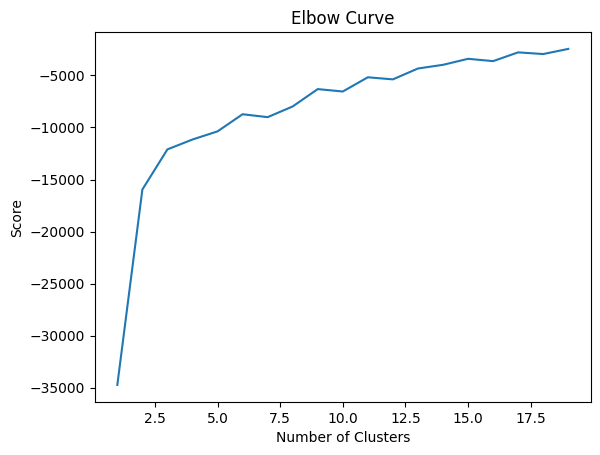

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Combinar todos los DataFrames preprocesados en uno solo
datos_combinados = pd.concat(maniobrasPreprocesadas, ignore_index=True)
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(datos_combinados).score(datos_combinados) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [10]:
# Definimos el número de clusters
num_clusters = 5

# Creamos el clasificador KMeans
kmeans = KMeans(n_clusters=num_clusters)

# Ajustamos el clasificador a los datos
kmeans.fit(maniobrasPreprocesadas[0])

# Obtenemos las etiquetas de los clusters y los centros de los clusters
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

maniobrasPreprocesadas[0]['Etiqueta'] = labels
maniobrasPreprocesadas[0].head(40)

,VariacionVelocidad,VariacionRevoluciones,VariacionAnguloVolante,VariacionAcelerador,VariacionFreno,VariacionMarcha,PedalEmbrague,Etiqueta
0,-1,-1,0,0,0,0,1,2
1,-1,-1,0,0,0,0,1,2
2,-1,-1,0,1,0,0,1,2
3,-1,1,0,1,0,0,1,1
4,-1,1,0,1,0,0,1,1
5,-1,1,0,1,0,0,1,1
6,-1,1,0,1,0,0,1,1
7,-1,1,0,1,0,0,1,1
8,-1,1,0,1,0,0,1,1
9,0,1,0,1,0,0,1,1
